This is the initial exploration of data for the proposed project to explore the hypothesis that
the valence of affect or arousal impacts the variance of diversity in colexification of words.

The null hypothesis is that there will be no difference in the diversity of words between (A)high and low arousal measures and (B) positive and negative valence measures when data is compared using an established library for these measures. 

Method: Using CLICS data set, and data from The NRC Valence, Arousal, and Dominance (NRC-VAD) Lexicon


From the the Clics Data I will find the 25 most diverse terms in colexification and chart them using the best translation to measure their affect and arousal rating in the NRC-VAD data. 

I will also extract the top 25% highest and lowest arousal and top 25% highest positive and negative valenced words and copare the sets on a scale of diversity in the CLICS data.

I will then test the distributions, and values against the mean. Get a t-value for the group and compare it to the alpha which I will establish as .05 to measure significance. 



In [1]:
import numpy as np
import pandas as pd
# the library below is useful for estimating the progress of a for loop
# the use of tqdm will be displayed in Demo 2
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("df_all_raw.csv")
df.columns = list(map(str.lower, df.columns))
df = df.drop(columns=['dataset_id', 'form_id', 'form', 'gloss_in_source', 'iso639p3code', 'mrc_word', 'kucera_francis_frequency'])

/var/folders/97/z59w4cy52k5chpbqvdcvkc280000gn/T/ipykernel_15493/2801652837.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_all_raw.csv")


In [3]:
num_languages = df['variety'].nunique()
print(f"Number of unique languages: {num_languages}")

num_languages_per_family = df.groupby("family")['variety'].count()
num_languages_per_family

sorted_data = num_languages_per_family.sort_values()
print(len(sorted_data))


Number of unique languages: 3050
201


In [4]:
#This puts all one word values into a dictionary and returns an affect measure between -1 and +1.
#I captured levels for phrases of two words (only apprx 300), in problems list which I will employ if I find a need.

valence_dict = {}
problems = []
with open('valence-NRC-VAD-Lexicon.txt') as txt:
    for line in txt.readlines():
        if len(line.split()) ==2:
            valence_dict[line.split()[0]]=float(line.split()[1])
        else:
            problems.append(line)
        
print(valence_dict['dread'],valence_dict['positive'] )

arousal_dict = {}
problems_arousal = []
with open('arousal-NRC-VAD-Lexicon.txt') as txt1:
    for line in txt1.readlines():
        if len(line.split()) ==2:
            arousal_dict[line.split()[0]]=float(line.split()[1])
        else:
            problems_arousal.append(line)
print(arousal_dict['murder'], arousal_dict['kiss'])
print(len(problems), len(problems_arousal))

-0.694 0.918
0.884 0.626
132 132


In [5]:
# in order to find the top and bottom Quartiles, I will need to intially look at unique
#conception_glosses to extract them and sort them.
conceptions = df['concepticon_gloss'].nunique()
print(f"Number of conceptions: {conceptions}")
#ordered_concepts = df.groupby(['concepticon_gloss'].nunique())

#I am employing the already written code for exploration of CLICS at the moment
                              
def per_lang_colexification(curr_df):
    """
    Calculate the colexification frequency of pairs of concepts present in the current language.
    """
    all_combos_dict = {}
    # We iterate through each row, which has the concepts associated with a specific word
    for i, row in curr_df.iterrows():
        # Get the current set of concepts
        a = row['concepticon_gloss']
        # Create all possible unique combinations of concepts, where each pair is alphabetically sorted
        combos = list(set(map(lambda x: tuple(sorted(x)), product(a, a))))
        # Ensure the concepts in the pair are not identical
        combos = [combo for combo in combos if combo[0] != combo[1]]
        # Add counts for a pair of combinations being colexified
        for combo in combos:
            if combo in all_combos_dict:
                all_combos_dict[combo] += 1
            else:
                all_combos_dict[combo] = 1

    # Create a DataFrame out of our dictionary and return the colexification counts for two concepts
    tmp = pd.DataFrame.from_dict(all_combos_dict, "index").reset_index()
    per_lang = pd.DataFrame(tmp['index'].tolist(), columns=['concept_1', "concept_2"])
    per_lang['colexification_count'] = tmp[0]
    return per_lang

def main():
    all_dfs = []
    for variety in tqdm(df['variety'].unique()):
        sub = df[df['variety'] == variety]
        agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
        agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
        colex = agg[agg['num_concepts']>1]
        colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
        # We skip any language where no concepts are colexified
        if colex.shape[0] == 0:
            continue
        curr_df = per_lang_colexification(colex)
        all_dfs.append(curr_df)
    mega = pd.concat(all_dfs)
    colex_counts = mega.groupby(["concept_1", "concept_2"]).sum().reset_index()
    return colex_counts

colex_counts = main()

ordered_count =colex_counts.sort_values(by='colexification_count')
quartiles = len(ordered_count)/4


Number of conceptions: 2919


100%|████████████████████████████████████████████████████████████████████████████████████████| 3050/3050 [02:36<00:00, 19.53it/s]


In [39]:
print(quartiles)
ordered = np.array(ordered_count)
print(ordered.shape)
high_value_test = []
not_found=[]
# Columns per row[0]concept_1 	[1]concept_2 	[2]colexification_count
for i in range(74250, 74300, 1):
    key1, key2, count = ordered[i][0].lower(), ordered[i][1].lower(), ordered[i][2]
    #print(key1, key2, count)
    if key1 in valence_dict.keys() and key2 in valence_dict.keys():
        high_value_test.append([key1,valence_dict[key1], key2, valence_dict[key2], count])
    else:
        not_found.append([key1, key2, count])

#print (len(high_value_test), len(not_found))
print(high_value_test)
concept1, concept2, label = [], [], []
for x in range(0,len(high_value_test)):
    concept1.append(high_value_test[x][1]), concept2.append(high_value_test[x][3]), label.append(high_value_test[x][4])
    
    


18582.5
(74330, 3)
[['lip', 0.082, 'mouth', 0.468, 124], ['drink', 0.3, 'eat', 0.462, 125], ['gourd', -0.146, 'pumpkin', 0.078, 125], ['long', 0.082, 'tall', 0.45, 126], ['deny', -0.368, 'refuse', -0.64, 128], ['fur', 0.166, 'skin', 0.138, 129], ['grandfather', 0.654, 'grandmother', 0.584, 130], ['chop', -0.5, 'cut', -0.02, 134], ['finger', -0.358, 'toe', -0.188, 134], ['oven', 0.166, 'stove', -0.068, 134], ['food', 0.776, 'meal', 0.666, 136], ['firewood', 0.04, 'wood', -0.012, 138], ['shovel', -0.146, 'spade', -0.062, 140], ['divide', -0.334, 'share', 0.518, 140], ['hill', 0.23, 'mountain', 0.396, 142], ['hold', -0.104, 'seize', 0.312, 149], ['language', 0.354, 'word', 0.104, 150], ['money', 0.688, 'silver', 0.368, 151], ['granddaughter', 0.646, 'grandson', 0.556, 151], ['fur', 0.166, 'leather', 0.02, 152], ['bathe', 0.354, 'wash', 0.27, 154], ['path', 0.18, 'road', 0.312, 155], ['catch', 0.062, 'seize', 0.312, 166], ['keep', 0.428, 'preserve', 0.674, 166], ['oar', -0.062, 'paddle', 0

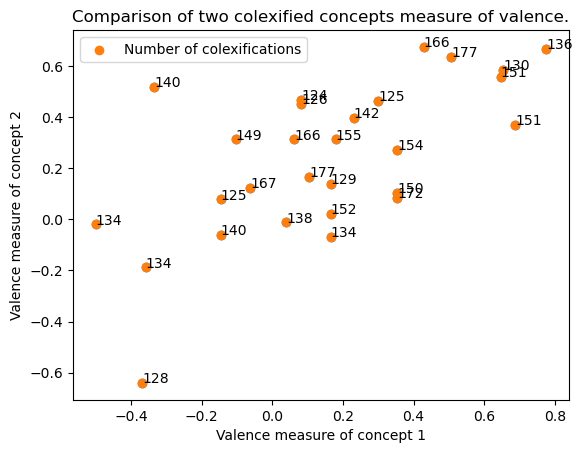

In [51]:
#this scatter plot is just proof of concept that i can extract and 
#put together some pertinant values in the data. It is not an
#example of any mathematical manipulation. 
fig, ax = plt.subplots()
x, y, labelval = np.array(concept1), np.array(concept2), np.array(label)
ax.scatter(x, y)
plt.scatter(x1, y1, label="Number of colexifications")

for i, txt in enumerate(labelval):
    ax.annotate(txt, (x[i], y[i]))
plt.legend(loc="upper left")
plt.title("Comparison of two colexified concepts measure of valence.")
plt.xlabel("Valence measure of concept 1")
plt.ylabel("Valence measure of concept 2")


plt.show()